In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import dates
from matplotlib.colors import LogNorm
from sunpy.time import parse_time
from sunpy.coordinates import frames
import sunpy.map
from astropy.coordinates import SkyCoord
from astropy import units as u
import datetime

## Read in the AR data over the past solar cycle and adjust extra columns

In [37]:
# all_data = pd.read_csv('all_ar_2010-2020.csv')
all_data = pd.read_csv('concat_1996-2020.csv')
tt = pd.to_datetime(all_data['event_starttime'])
times = [(t - tt[0]).total_seconds() for t in tt]
all_data['times'] = times
all_data['tt'] = tt
all_data['area_arcsec'] = all_data['area_atdiskcenter']/(725**2)
# get all unique days over the solar cycle
tstart = parse_time(all_data['event_starttime'].min()).datetime
tfinal = parse_time(all_data['event_endtime'].max()).datetime
time_over = [tstart.strftime('%Y-%m-%dT%H:%M:%S')]
t0 = tstart
while t0 < tfinal:
    t0 = t0 + datetime.timedelta(days=1)
    time_over.append(t0.strftime('%Y-%m-%dT%H:%M:%S'))
all_data_test = all_data.set_index('tt')

### Work out the number of sunspots and active regions as a function of day 
Also work out the relative sunspot number

In [38]:
spots = []
no_ar = []
for i in range(len(time_over)):
    data_for_day = all_data[all_data['event_starttime'].isin([time_over[i]])]
    no_spots = data_for_day['ar_numspots'].sum()
    spots.append(no_spots)
    no_ar.append(len(data_for_day))
spots_ar = pd.Series(spots, index=parse_time(time_over).datetime)
ar_no = pd.Series(no_ar, index=parse_time(time_over).datetime)
ssn_tots = 10*ar_no+spots_ar

## Read in SILSO sunspot data for comparison

In [39]:
def read_ssn():
    ssn = pd.read_csv("../SN_m_tot_V2.0.csv", names=['year', 'month', 'decimal_date', \
                                                  'ssn', 'ssn_dev', 'number_obs', 'indicator'], 
             delimiter=';')
    years = ssn['year'].values; months = ssn['month']
    tt = [datetime.datetime(ssn['year'][i], ssn['month'][i], 1) for i in range(len(ssn))]


    ssn['times'] = tt

    return ssn.set_index('times')
ssn = read_ssn()

## Read in the flare data too

In [40]:
all_flares = pd.read_csv("../since_1986_c1_solarcycle_flares.csv") 
all_flares = all_flares[all_flares['goes_class']!=0] 
all_flares = all_flares.drop_duplicates(subset='event_starttime')
flares = all_flares[all_flares['event_starttime']>tstart.strftime('%Y-%m-%d')]

## Test out with some plots

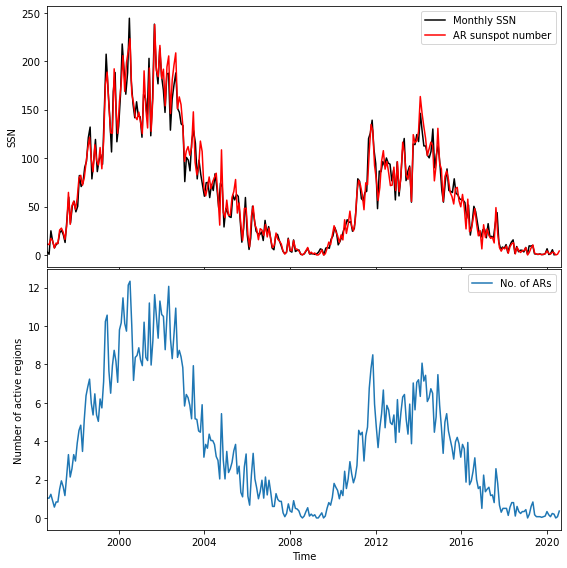

In [41]:
fig, axx = plt.subplots(2, figsize=(8, 8), sharex=True)
ax = axx[0]
ax1 =axx[1]
ax.plot(ssn['ssn'].truncate(tstart, tfinal), label='Monthly SSN', color='k')
ax.plot(ssn_tots.resample('30D').mean(), color='r', label='AR sunspot number')
ax.set_xlim(tstart, tfinal)
ax.set_ylabel('SSN')

ax.legend()

ax1.plot(ar_no.resample('30D').mean(), label='No. of ARs')
ax1.set_ylabel('Number of active regions')
ax1.legend()
ax1.set_xlabel('Time')

plt.tight_layout()
plt.subplots_adjust(hspace=0.01)

(728903.0, 737656.9999884259)

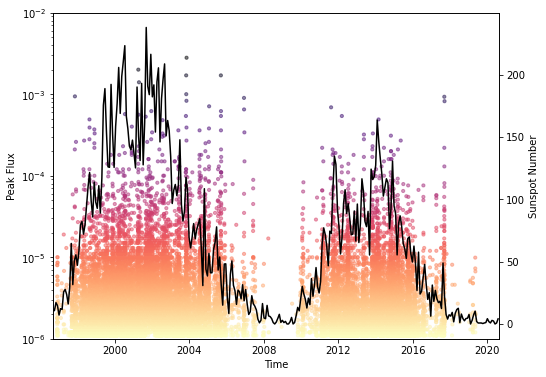

In [42]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_yscale('log')
ax.scatter(pd.to_datetime(flares['event_peaktime']), flares['goes_class'], 
           alpha=0.5, s=10, cmap='magma_r', c=flares['goes_class'], norm=LogNorm())
ax.set_ylim(1e-6, 1e-2)
ax.set_xlabel('Time')
ax.set_ylabel('Peak Flux')

ax2 = ax.twinx()
ax2.plot(ssn_tots.resample('30D').mean(), color='k')
ax2.set_ylabel('Sunspot Number')
ax2.set_xlim(tstart, tfinal)

## Plot positions on disk 

Text(0, 0.5, 'Y (arcsec)')

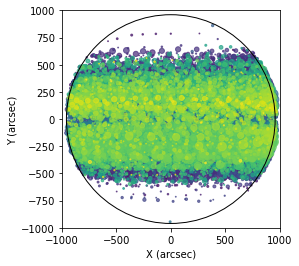

In [43]:
circle1 = plt.Circle((0, 0), 960, color='k', fill=False)
plt.scatter(all_data['hpc_x'], all_data['hpc_y'], s=10*all_data['area_atdiskcenter']/all_data['area_atdiskcenter'].mean(),
            c=times, alpha=0.7)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
ax = plt.gca()
ax.add_artist(circle1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X (arcsec)')
plt.ylabel('Y (arcsec)')

# Lets break up these solar cycles

In [297]:
sc23 = all_data_test.truncate('1996-09-01', '2008-09-01')
sc24 = all_data_test.truncate('2008-09-01', '2020-09-01')

(728903.0, 737656.9999884259)

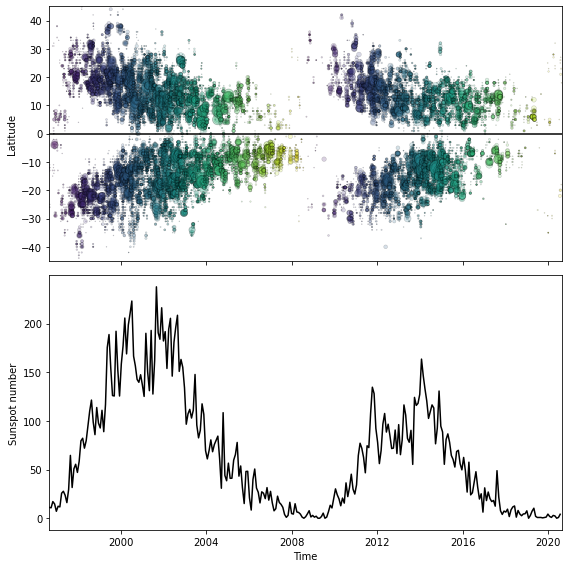

In [298]:
fig, axx = plt.subplots(2, figsize=(8, 8), sharex=True)
ax = axx[0]
ax1 = axx[1]
ax.scatter(sc23.index, sc23['hgc_y'], 
            alpha=0.2, c=sc23['times'], 
            s=10*sc23['area_atdiskcenter']/sc23['area_atdiskcenter'].mean(),
            #s=100*all_data['ar_numspots']/all_data['ar_numspots'].mean(),
            cmap='viridis', edgecolor='k', lw=0.5)

ax.scatter(sc24.index, sc24['hgc_y'], 
            alpha=0.2, c=sc24['times'], 
            s=10*sc24['area_atdiskcenter']/sc24['area_atdiskcenter'].mean(),
            #s=100*all_data['ar_numspots']/all_data['ar_numspots'].mean(),
            cmap='viridis', edgecolor='k', lw=0.5)
ax.axhline(0, color='k')
ax.set_ylim(-45, 45)
ax.set_ylabel('Latitude')
ax1.plot(ssn_tots.resample('30D').mean(), color='k')
ax1.set_ylabel('Sunspot number')
ax1.set_xlabel('Time')
plt.tight_layout()
ax.set_xlim(tstart, tfinal)

In [299]:
# create an empty sunpy.map.Map
data_arr = np.zeros((1200, 1200))
coord = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=frames.Helioprojective(observer='Earth', obstime=time_over[i]))
header = sunpy.map.make_fitswcs_header(data_arr, coord, scale=[2, 2]*u.arcsec/u.pix)
mapy = sunpy.map.Map(data_arr, header)

In [300]:
num_points = 100
lat_value = [-60, -45, -30, -15, 0, 15, 30, 45, 60]*u.deg
lon_value = [-60, -45, -30, -15, 0, 15, 30, 45, 60]*u.deg
lats = []
lons = []

for l in range(len(lat_value)):
    lat0 = SkyCoord(np.ones(num_points) * lat_value[l],
                np.linspace(-90, 90, num_points) * u.deg,
                frame=frames.HeliographicStonyhurst)
    lon0 = SkyCoord(np.linspace(-80, 80, num_points) * u.deg,
                np.ones(num_points) * lon_value[l], frame=frames.HeliographicStonyhurst)
    lat00 = lat0.transform_to(mapy.coordinate_frame)
    lon00 = lon0.transform_to(mapy.coordinate_frame)
    lats.append(lat00)
    lons.append(lon00)
coords_test = []
lat_value_plot = [-45, -30, -15, 0, 15, 30, 45]
for l in lat_value_plot:
    coords = SkyCoord(90*u.deg, l*u.deg, frame=frames.HeliographicStonyhurst).transform_to(mapy.coordinate_frame)
    coords_test.append(mapy.world_to_pixel(coords))
    

    

In [301]:
str(lat_value[0])

'-60.0 deg'

In [302]:
SkyCoord(0*u.deg, lat_value[0], frame=frames.HeliographicStonyhurst)

<SkyCoord (HeliographicStonyhurst: obstime=None): (lon, lat, radius) in (deg, deg, km)
    (0., -60., 695700.)>

<ipython-input-328-8171367a416c>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


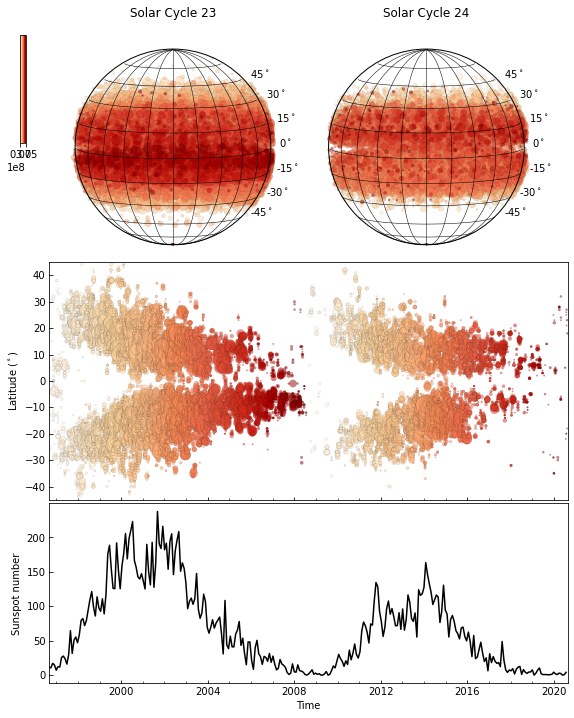

In [328]:
fig = plt.figure(figsize=(8, 10))
# two maps side by side
ax1a = pylab.axes([0.08, 0.58, 0.43, 0.43], projection=mapy)
ax1b = pylab.axes([0.52, 0.58, 0.43, 0.43], projection=mapy)
# middle butterfly
ax2 = pylab.axes([0.08, 0.305, 0.9, 0.33])
# bottom ssn plot
ax3 = pylab.axes([0.08, 0.05, 0.9, 0.25], sharex=ax2)

# size of dots
sizey23 = 10*sc23['area_atdiskcenter']/sc23['area_atdiskcenter'].mean()
sizey24 = 10*sc24['area_atdiskcenter']/sc24['area_atdiskcenter'].mean()
    
sizey23 = 5*sc23['ar_numspots']
sizey24 = 5*sc24['ar_numspots']

cmap='OrRd'
    
##### FIRST SOLAR CYCLE 23 ########
# circle1 = plt.Circle((0, 0), 960, color='k', fill=False)
mapy.plot(axes=ax1a, alpha=0.0)
mapy.draw_limb(color='k')
mapy.draw_grid(color='k', lw=0.5)
cc = ax1a.scatter((sc23['hpc_x'].values*u.arcsec).to(u.deg),
			 (sc23['hpc_y'].values*u.arcsec).to(u.deg),
			  s=sizey23, edgecolor='k', lw=0.1,
              c=sc23['times'], alpha=0.5,
              transform=ax1a.get_transform('world'), cmap=cmap)

ax1a.set_xlabel('X (arcsec)')
ax1a.set_ylabel('Y (arcsec)')
ax1a.tick_params(axis='both',direction='in')
ax1a.set_title('Solar Cycle 23').set_position([.5, 1.0])
ax1a.set_axis_off()
for l in range(len(lats)):
    ax1a.plot_coord(lats[l], color='k', lw=0.5)
    ax1a.plot_coord(lons[l], color='k', lw=0.5)


##### FIRST SOLAR CYCLE 24 ########
# circle1 = plt.Circle((0, 0), 960, color='k', fill=False)

mapy.plot(axes=ax1b, alpha=0.0, title='Solar Cycle 24')
mapy.draw_limb(color='k')
mapy.draw_grid(color='k', lw=0.5)
ax1b.scatter((sc24['hpc_x'].values*u.arcsec).to(u.deg), 
			 (sc24['hpc_y'].values*u.arcsec).to(u.deg), 
			 s=sizey24, edgecolor='k', lw=0.1,
             c=sc24['times'], alpha=0.5,
            transform=ax1b.get_transform('world'), cmap=cmap)

cax = fig.add_axes([0.03, 0.8, 0.01, 0.15])
cbar = fig.colorbar(cc, cax=cax, orientation='horizontal', ticks=[0, sc23['times'].max()])
cbar.set_alpha(1)
cbar.draw_all()
cbar.ax.set_yticklabels(['start SC', 'end SC'])

ax1b.set_xlabel('X (arcsec)')
ax1b.set_ylabel(' ')
ax1b.tick_params(which='both',direction='in')
ax1b.tick_params(axis='y', labelleft=False)
ax1b.set_title('Solar Cycle 24').set_position([.5, 1.0])
ax1b.set_axis_off()
for l in range(len(lats)):
    ax1b.plot_coord(lats[l], color='k', lw=0.5)
    ax1b.plot_coord(lons[l], color='k', lw=0.5)

for c in range(len(coords_test)):
    ax1a.text(coords_test[c].x.value+40, coords_test[c].y.value, str(lat_value_plot[c])+'$^\circ$')
    ax1b.text(coords_test[c].x.value+40, coords_test[c].y.value, str(lat_value_plot[c])+'$^\circ$')
    
    ##### BUTTERFLY DIAGRAM FOR BOTH ########
ax2.scatter(sc23.index, sc23['hgc_y'], 
            alpha=0.5, c=sc23['times'], 
            s=sizey23/2,
            #s=100*all_data['ar_numspots']/all_data['ar_numspots'].mean(),
            cmap=cmap, edgecolor='k', lw=0.1)

ax2.scatter(sc24.index, sc24['hgc_y'], 
            alpha=0.5, c=sc24['times'], 
            s=sizey24/2,
            #s=100*all_data['ar_numspots']/all_data['ar_numspots'].mean(),
            cmap=cmap, edgecolor='k', lw=0.1)

ax2.set_ylim(-45, 45)
ax2.set_ylabel('Latitude ($^\circ$)')
ax2.tick_params(which='both',direction='in', labelbottom=False)
ax2.xaxis.set_major_locator(dates.YearLocator(4))
ax2.xaxis.set_minor_locator(dates.YearLocator(1))  
ax2.xaxis.set_major_formatter(dates.DateFormatter('%Y'))  

##### SUNSPOT NUMBER AS A FUNCTION OF TIME ########
ax3.plot(ssn_tots.resample('30D').mean(), color='k')
ax3.set_ylabel('Sunspot number')
ax3.set_xlabel('Time')
plt.tight_layout()
ax3.set_xlim(tstart, tfinal)
ax3.tick_params(which='both',direction='in')

# plt.savefig('full_plot_test.png', dpi=200)
# plt.close()



In [324]:
sc23['times'].max()

375062400.0

(728903.0, 737656.9999884259)

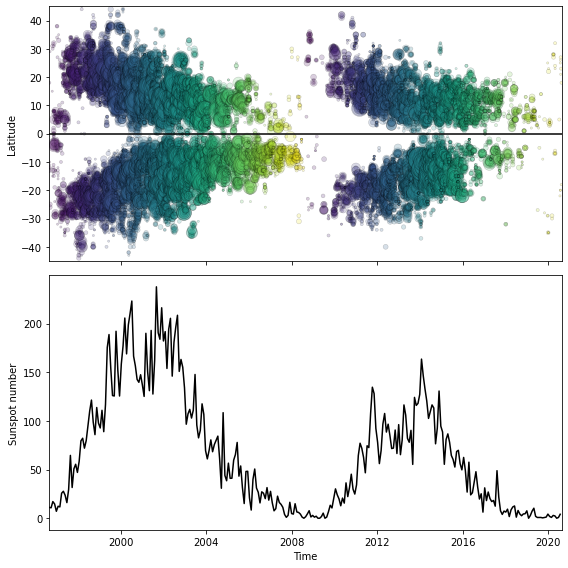

In [304]:
fig, axx = plt.subplots(2, figsize=(8, 8), sharex=True)
ax = axx[0]
ax1 = axx[1]
ax.scatter(sc23.index, sc23['hgc_y'], 
            alpha=0.2, c=sc23['times'], 
            s=5*sc23['ar_numspots'].values,
            #s=100*all_data['ar_numspots']/all_data['ar_numspots'].mean(),
            cmap='viridis', edgecolor='k', lw=0.5)

ax.scatter(sc24.index, sc24['hgc_y'], 
            alpha=0.2, c=sc24['times'], 
            s=5*sc24['ar_numspots'].values,
            #s=100*all_data['ar_numspots']/all_data['ar_numspots'].mean(),
            cmap='viridis', edgecolor='k', lw=0.5)
ax.axhline(0, color='k')
ax.set_ylim(-45, 45)
ax.set_ylabel('Latitude')
ax1.plot(ssn_tots.resample('30D').mean(), color='k')
ax1.set_ylabel('Sunspot number')
ax1.set_xlabel('Time')
plt.tight_layout()
ax.set_xlim(tstart, tfinal)

Text(0.5, 1.0, 'Solar cycle 24')

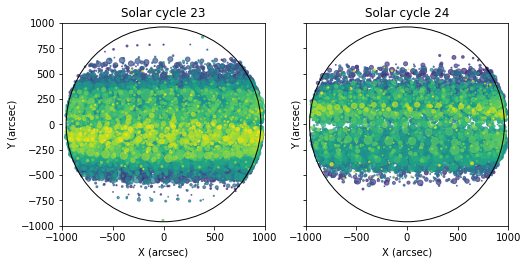

In [305]:
fig, axx = plt.subplots(1, 2, sharey=True, figsize=(8, 6))
ax = axx[0]
ax1 = axx[1]
circle1 = plt.Circle((0, 0), 960, color='k', fill=False)
ax.scatter(sc23['hpc_x'], sc23['hpc_y'], s=10*sc23['area_atdiskcenter']/sc23['area_atdiskcenter'].mean(),
            c=sc23['times'], alpha=0.7)
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)

ax.add_artist(circle1)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (arcsec)')
ax.set_ylabel('Y (arcsec)')

circle1 = plt.Circle((0, 0), 960, color='k', fill=False)
ax1.scatter(sc24['hpc_x'], sc24['hpc_y'], s=10*sc24['area_atdiskcenter']/sc24['area_atdiskcenter'].mean(),
            c=sc24['times'], alpha=0.7)
ax1.set_xlim(-1000, 1000)
ax1.set_ylim(-1000, 1000)

ax1.add_artist(circle1)
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlabel('X (arcsec)')
ax1.set_ylabel('Y (arcsec)')

ax.set_title('Solar cycle 23')
ax1.set_title('Solar cycle 24')

# Plot per i

In [13]:
def plot_for_date(all_data, i, savedir='/Users/lahayes/space_weather_stuff/SolarStatsStuff/ar_analysis/plots/'):
    """
    datey should be str in format "YYYY-mm-ddTHH:MM:SS"
    """
    if i < 10:
        data_for_past = all_data[all_data['event_starttime'].isin(time_over[0:i])]
    else:
        data_for_past = all_data[all_data['event_starttime'].isin(time_over[i-10:i])]
        
        
    data_for_day = all_data[all_data['event_starttime'].isin([time_over[i]])]
    
    fig, ax = plt.subplots(figsize=(5,5))
    circle1 = plt.Circle((0, 0), 960, color='k', fill=False)
    if len(data_for_day) > 0:
        ax.scatter(data_for_day['hpc_x'], data_for_day['hpc_y'], 
                   s=10*data_for_day['area_atdiskcenter']/all_data['area_atdiskcenter'].mean(), 
                   alpha=0.7, color='k', marker='x')
        
    if len(data_for_past)>0:
        ax.scatter(data_for_past['hpc_x'], data_for_past['hpc_y'], 
                   s=10*data_for_past['area_atdiskcenter']/all_data['area_atdiskcenter'].mean(), 
                   c=data_for_past['times'],
                   cmap='Reds',
                   alpha=0.7)        
    ax.set_xlim(-1000, 1000)
    ax.set_ylim(-1000, 1000)

    
    ax.set_xlabel('X arcsec')
    ax.set_ylabel('Y arscec')
    ax.set_title(time_over[i])
    ax.add_artist(circle1)
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()
#     plt.savefig(savedir + 'test_{:04d}.png'.format(i), dpi=200)
#     plt.close()


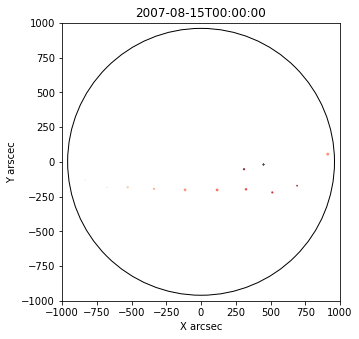

In [14]:
plot_for_date(all_data, 4000)

# Plot as a SunPy map

In [49]:
# create an empty sunpy.map.Map
data_arr = np.zeros((1200, 1200))
coord = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=frames.Helioprojective(observer='Earth', obstime=time_over[i]))
header = sunpy.map.make_fitswcs_header(data_arr, coord, scale=[2, 2]*u.arcsec/u.pix)
mapy = sunpy.map.Map(data_arr, header)


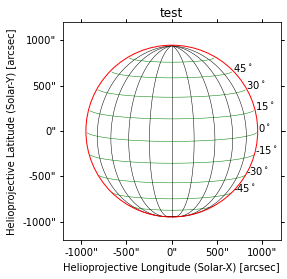

In [215]:
ax = plt.subplot(projection=mapy)
mapy.plot(alpha=0.)
# mapy.draw_grid(color='r',grid_spacing=15*u.deg)
mapy.draw_limb(color='r')
# c1, c2 = ax.coords
# c1.tick_params(which='both', labelbottom=False, bottom=False)
# c2.set_ticks_position('bl')
# test_coord30 = SkyCoord(90*u.deg, 30*u.deg, frame=frames.HeliographicStonyhurst,observer='earth', obstime=mapy.date)
# test_coord15 = SkyCoord(90*u.deg, 15*u.deg, frame=frames.HeliographicStonyhurst,observer='earth', obstime=mapy.date)
# test_coord50 = SkyCoord(90*u.deg, 0*u.deg, frame=frames.HeliographicStonyhurst,observer='earth', obstime=mapy.date)
# ax.plot_coord(test_coord30, color='b', marker='x')
# ax.plot_coord(test_coord15, color='b', marker='x')
# ax.plot_coord(test_coord50, color='b', marker='x')

# testy = mapy.world_to_pixel(test_coord30)
# ax.text(testy.x.value, testy.y.value, '30$^\circ$ ')

tt1 = ax.set_title('test').set_position([.5, 1.0])
# tt1.set_position([.5, 1.0])

num_points = 100
lat_value = [-60, -45, -30, -15, 0, 15, 30, 45, 60]*u.deg
lon_value = [-60, -45, -30, -15, 0, 15, 30, 45, 60]*u.deg
lats = []
lons = []
for l in range(len(lat_value)):
    lat0 = SkyCoord(np.ones(num_points) * lat_value[l],
                np.linspace(-90, 90, num_points) * u.deg,
                frame=frames.HeliographicStonyhurst)
    lon0 = SkyCoord(np.linspace(-80, 80, num_points) * u.deg,
                np.ones(num_points) * lon_value[l], frame=frames.HeliographicStonyhurst)
    lat00 = lat0.transform_to(mapy.coordinate_frame)
    lon00 = lon0.transform_to(mapy.coordinate_frame)
    lats.append(lat00)
    lons.append(lon00)

for l in range(len(lats)):
    ax.plot_coord(lats[l], color='k', lw=0.5)
    ax.plot_coord(lons[l], color='g', lw=0.5)
    
for c in range(len(coords_test)):
    ax.text(coords_test[c].x.value, coords_test[c].y.value, str(lat_value_plot[c])+'$^\circ$')

In [202]:
str(lat_value[0])

'-60.0 deg'

In [157]:
np.array(lats)

array([[<SkyCoord (Helioprojective: obstime=2020-08-20T00:00:00.000, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2020-08-20T00:00:00.000): (lon, lat, radius) in (deg, deg, m)
    (0., 6.87213047, 1.51376006e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (4.10220346e-14, -940.62592963, 1.51460824e+08)>,
        <SkyCoord (Helioprojective: obstime=2020-08-20T00:00:00.000, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2020-08-20T00:00:00.000): (lon, lat, radius) in (deg, deg, m)
    (0., 6.87213047, 1.51376006e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (21.2580136, -942.7923743, 1.51445294e+08)>,
        <SkyCoord (Helioprojective: obstime=2020-08-20T00:00:00.000, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2020-08-20T00:00:00.000): (lon, lat, radius) in (deg, deg, m)
    (0., 6.87213047, 1.51376006e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (42.49900118, -944.01028221, 1.5

In [51]:



submap = mapy.submap(SkyCoord(-1100*u.arcsec, -1400*u.arcsec, frame=mapy.coordinate_frame),
                     SkyCoord(1100*u.arcsec, 1400*u.arcsec, frame=mapy.coordinate_frame))

    (0., 6.87213047, 1.51376006e+11)>): (Tx, Ty) in arcsec
    (1100., 1400.)> as keyword args. From version 2.1 passing these as positional arguments will result in an error. [sunpy.util.decorators]


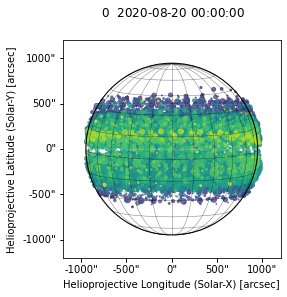

In [64]:
ax = plt.subplot(projection=mapy)
mapy.plot(alpha=0.)
mapy.draw_limb(color='k') 
mapy.draw_grid(color='k', lw=0.5)

ax.scatter((sc24['hpc_x'].values*u.arcsec).to(u.deg),
           (sc24['hpc_y'].values*u.arcsec).to(u.deg), 
            cmap='viridis',
            c=sc24['times'], alpha=0.7,
            s=10*sc24['area_atdiskcenter']/sc24['area_atdiskcenter'].mean(),
            #s=np.sqrt(sc24['area_arcsec']), 
            transform=ax.get_transform('world')) 

Text(0, 0.5, 'Y (arcsec)')

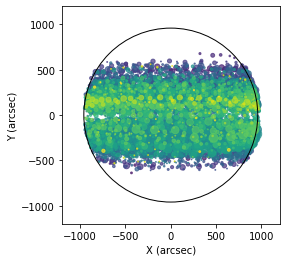

In [56]:
fig,ax1 = plt.subplots()
circle1 = plt.Circle((0, 0), 960, color='k', fill=False)
ax1.scatter(sc24['hpc_x'], sc24['hpc_y'], s=10*sc24['area_atdiskcenter']/sc24['area_atdiskcenter'].mean(),
            c=sc24['times'], alpha=0.7)
ax1.set_xlim(-1200, 1200)
ax1.set_ylim(-1200, 1200)

ax1.add_artist(circle1)
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlabel('X (arcsec)')
ax1.set_ylabel('Y (arcsec)')


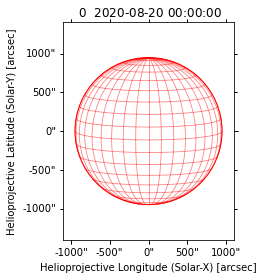

In [19]:
ax = plt.subplot(projection=submap)
submap.plot(alpha=0)
submap.draw_limb(color='r')
grid_spacing = 10*u.deg
lon_space = lat_space = grid_spacing
# c1, c2 = ax.coords
# c1.set_ticks_position('bl')
# c2.set_ticks_position('bl')
overlay = ax.get_coords_overlay('heliographic_stonyhurst')
lon = overlay[0]
lat = overlay[1]

# lon.coord_wrap = 180
# #lon.set_major_formatter('dd')
# lon.set_axislabel('Solar Longitude', minpad=0.8)
# lat.set_axislabel('Solar Latitude', minpad=0.9)
# lon.set_ticks_position('tr')
# lat.set_ticks_position('tr')
grid_kw = {'color': 'red', 'zorder': 100, 'alpha': 0.5}
tick_color = 'k'

overlay.grid(**grid_kw)
# x, y = ax.title.get_position()
# ax.title.set_position([x, y + 0.08])
lon.set_ticks(spacing=lon_space, color='k')
lat.set_ticks(spacing=lat_space, color='k')

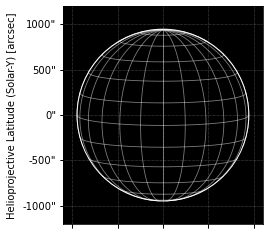

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=submap)
submap.plot(title='')
submap.draw_limb()
submap.draw_grid()
ax.tick_params(axis='x', labelleft=False)
plt.show()

In [21]:
? lon.set_ticklabel_position

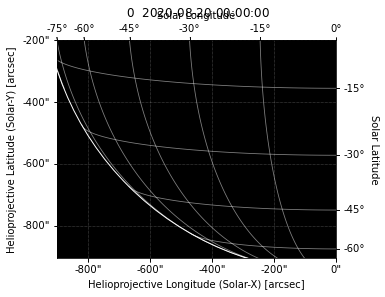

In [22]:
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.data.sample
import sunpy.map

swap_map = sunpy.map.Map(sunpy.data.sample.SWAP_LEVEL1_IMAGE)

top_right = SkyCoord(0 * u.arcsec, -200 * u.arcsec, frame=mapy.coordinate_frame)
bottom_left = SkyCoord(-900 * u.arcsec, -900 * u.arcsec, frame=mapy.coordinate_frame)
swap_submap = mapy.submap(bottom_left, top_right=top_right)

fig = plt.figure()
ax = fig.add_subplot(111, projection=swap_submap)
swap_submap.plot()
swap_submap.draw_limb()
swap_submap.draw_grid()
plt.show()